<font size=7 face="courier">Cart-Pole Analysis Source Code

This is the code used to create the diagrams in the notebook, `cartpole_analysis.ipynb`. I recommend you at least go through some of these functions to understand how to implement your own analysis functions.

In [ ]:
print("Loading: final_analysis_source_code.ipynb...")

Loading: final_analysis_source_code.ipynb...


Import packages

In [ ]:
import pandas as pd
import numpy as np
import pickle
import pytz
import sys
import csv
import json
import random
import zipfile
import glob
import argparse  # Import argparse for command-line arguments
from datetime import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # For color normalization

from pathlib import Path
from braingeneers.analysis.analysis import SpikeData
import braingeneers.data.datasets_electrophysiology as ephys


import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d

import gymnasium as gym
import pygame

import spikedata
from spikedata.spikedata import SpikeData
#from braindance.analysis.mapping import Mapping # Moved import higher

from braindance.analysis import data_loader
from braindance.core.spikesorter.rt_sort import RTSort

import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets from IPython.display import HTML, display, Javascript, clear_output,
from IPython.display import HTML, display, Javascript, clear_output

try:
    from braingeneers.utils import smart_open_braingeneers as smart_open
    bgr=True
except:
    print("Could not import smart_open_braingeneers")
    import smart_open
    bgr=False

Here is some minor stuff to help set up the notebook :

In [3]:
Timezone = pytz.timezone("America/Los_Angeles")

# <font color="blue"> Loading Data

In [4]:
def load_pickle(p):
    with open(p, 'rb') as f:
        data = pickle.load(f)
    return data

def get_save_path(filename_base):
    """Generates a unique save path, appending a number if the file exists."""
    save_path = output_dir / f"{filename_base}.png"
    if save_path.exists():
        n_existing = len(list(output_dir.glob(f"{filename_base}_*.png")))
        save_path = output_dir / f"{filename_base}_{n_existing+1}.png"
    return save_path


In [5]:
dataset_dir = Path("data")
metadata_path = dataset_dir / 'metadata.pkl'
baseline_sd_path = dataset_dir / 'baseline_spike_data.pkl'
adaptive_sd_path = dataset_dir / 'exp1_cartpole_long_6_spike_data.pkl'
random_sd_path = dataset_dir / 'exp1_cartpole_long_7_spike_data.pkl'
none_sd_path = dataset_dir / 'exp1_cartpole_long_8_spike_data.pkl'
adaptive_logs_path = dataset_dir / 'exp1_cartpole_long_6_logs.pkl'
random_logs_path = dataset_dir / 'exp1_cartpole_long_7_logs.pkl'
none_logs_path = dataset_dir / 'exp1_cartpole_long_8_logs.pkl'
metadata = load_pickle(metadata_path)
baseline_sd = load_pickle(baseline_sd_path)
adaptive_sd = load_pickle(adaptive_sd_path)
adaptive_logs = load_pickle(adaptive_logs_path) # Logs might be needed later
random_sd = load_pickle(random_sd_path)
random_logs = load_pickle(random_logs_path)
none_sd = load_pickle(none_sd_path)
none_logs = load_pickle(none_logs_path)



In [ ]:
datasets = ["Baseline", "Dataset 6", "Dataset 7", "Dataset 8"]
#sd_main = baseline_sd
#logs_main = 0

def dataSelect(sd_name):
    global sd_main
    global logs_main
    msg = "Successfully loaded " + sd_name + " logs into : <logs_main>"
    if sd_name == "Baseline":
        sd_main = baseline_sd
        print("Warning: no logs provided, some functions may not work for this data")
        msg = "No logs loaded: <logs_main = -1>"
        logs_main = -1
    elif sd_name == "Dataset 6":
        sd_main = adaptive_sd
        logs_main = adaptive_logs
    elif sd_name == "Dataset 7":
        sd_main = random_sd
        logs_main = random_sd
    elif sd_name == "Dataset 8": 
        sd_main = none_sd
        logs_main = none_logs
    else:
        raise Exception("Invalid data selection")
    print("Successfully loaded " + sd_name + " into : <sd_main>")
    print(msg)
    return

interact_manual( dataSelect, sd_name=datasets )

interactive(children=(Dropdown(description='sd_name', options=('Baseline', 'Dataset 6', 'Dataset 7', 'Dataset …

<function __main__.dataSelect(sd_name)>

# <font color="Green"> Analysis Plots

Here is the source code for all the figures used in the main notebook. Feel free to use these as reference/inspiration when working on your own analysis methods!

## <font color="Green">Generic Analysis


In [7]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

def raster_analysis(sd, seconds=20):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='r')

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()

    raster_analysis(sd_main, sd_main.length/1000)


In [ ]:
def plot_raster_pretty(sd, title="Spike Raster", l1=-10, l2=False, xsize=20, ysize=6, analyze=False):
    """
    Plots a configuable raster plot of the spike data.
        sd : spike data object from braingeneers
        title : Title of the plot
        l1 : start time in seconds
        l2 : end time in seconds
        xsize : width of the plot
        ysize : height of the plot
        analyze : If True, will plot the population rate as well
    """

    if l2==False:
        l2 = sd.length / 1000 + 10
    
    idces, times = sd.idces_times()
    
    if analyze == True:
        # Get population rate for everything
        pop_rate = sd.binned(bin_size=1)  # in ms
        # Lets smooth this to make it neater
        sigma = 5
        pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
        t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

        # Determine the stop_time if it's not provided
        if l2 is None:
            l2 = t[-1]

        # Filter times and idces within the specified start and stop times
        mask = (times >= l1 * 1000) & (times <= l2 * 1000)
        times = times[mask]
        idces = idces[mask]

    fig, ax = plt.subplots(figsize=(xsize, ysize))
    fig.suptitle(title)
    ax.scatter(times/1000,idces,marker='|',s=1)
    
    if analyze == True:
        ax2 = ax.twinx()
        ax2.plot(t, pop_rate_smooth, c='r', alpha=0.6)
        ax2.set_ylabel('Firing Rate')
        
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.xlim(l1, l2)
    plt.show()

#plot_raster_pretty(sd_main, analize=True)

In [63]:
def interspike(sd):
    # Interspike-intervals of 2 select neurons
    isis_raw = sd.interspike_intervals()
    # Remove all isi's greater than 100ms. As there are likely neurons not following periodic firing pattern
    isis=[]
    for i in range(len(isis_raw)):   
        isi=isis_raw[i]
        isis = isis + isi[isi<100].tolist() 
        
    # Plot the isi's
    plt.xlim(0,100)
    plt.hist(isis, bins=50)
    plt.xlabel('Time bin(ms)')
    plt.ylabel('ISI count')
    plt.show()

#interspike(sd_main)

In [69]:
def get_sttc(sd):
    """
    Returns the spike time tiling coefficient of a spike data object
        sd : spike data object from braingeneers
        returns : N x N matrix of STTC values
    """

    sttc = sd.spike_time_tilings()
    return sttc

def correlation(sd):
    """
    Returns the correlation matrix of a spike data object
        sd : spike data object from braingeneers
        returns : N x N matrix of correlation values
    """
    
    corr = np.zeros((sd.N,sd.N)) #inds by inds
    
    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma)
    corr=np.corrcoef( dense_raster )
        
    return corr;

def eigenvalues_eigenvectors(sd): # gets the eigenvalues and eigenvectors of a matrix
    """
    returns the eigenvalues and eigenvectors of a matrix
        sd : spike data object from braingeneers
        returns : eigenvalues, eigenvectors
    """

    W, U = np.linalg.eigh(sd)
    # The rank of A can be no greater than the smaller of its
    # dimensions, so cut off the returned values there.
    rank = min(*sd.shape)
    U = U[:,-rank:]
    sgn = (-1)**(U[0,:] < 0)
    # Also reverse the order of the eigenvalues because eigh()
    # returns them in ascending order but descending makes more sense.
    return W[-rank:][::-1], (U*sgn[np.newaxis,:])[:, ::-1]


In [ ]:
def correlation_plot(sd):
    # Correlation
    corr = np.zeros((sd.N,sd.N)) #inds by inds
    #corr = np.nan_to_num(corr)
    
    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma) 
    corr=np.corrcoef( dense_raster )
    
    corr = np.nan_to_num(corr) 

    im = plt.imshow(corr)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show() 

def STTC_plot(sd):
    # STTC

    sttc = get_sttc(sd)
    
    sttc = np.nan_to_num(sttc)

    im = plt.imshow(sttc)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.colorbar(im, fraction=0.046, pad=0.04)  # Add colorbar
    plt.show() 

def plot_evectmatrix(sd):
    """
    Plots the eigenvectors of the correlation and STTC matrices for a given spike data object.
        sd : spike data object from braingeneers
    """
    
    fig, plot = plt.subplot_mosaic("AB", figsize=(14,7))
    
    corr = correlation(sd)
    sttc = get_sttc(sd)

    corr = np.nan_to_num(corr) 
    sttc = np.nan_to_num(sttc)



    Wcorr, Ucorr = eigenvalues_eigenvectors(corr)
    Wsttc, Usttc = eigenvalues_eigenvectors(sttc)

    # Plot Correlation Matrix
    pltA = plot["A"].imshow(Ucorr[:,:2*len(Ucorr)].T, interpolation='none', cmap="magma")
    #plot["A"].gca().set_aspect('auto')
    plot["A"].set_ylabel('Eigenvector Number')
    plot["A"].set_xlabel('Observation Dimension')
    plot["A"].set_title('Eigenvectors of Correlation')
    fig.colorbar(pltA, ax=plot["A"], shrink=0.7)
    
    # Plot STTC matrix
    pltA = plot["B"].imshow(Usttc[:,:2*len(Usttc)].T, interpolation='none', cmap="magma")
    #plot["B"].gca().set_aspect('auto')
    plot["B"].set_ylabel('Eigenvector Number')
    plot["B"].set_xlabel('Observation Dimension')
    plot["B"].set_title('Eigenvectors of STTC')
    fig.colorbar(pltA, ax=plot["B"], shrink=0.7)

#correlation_plot(sd_main)
#STTC_plot(sd_main)
#plot_evectmatrix(sd_main)

## <font color="Green">Mappings

### <font color="red">Requiment: Mapping Class (Not important for Students)

<font color="red"><b>Warning:</b> I do not reccomend reading this code, it is only required for other plots to run. You do not need to know it to finish this HW.

In [102]:
class Mapping:
    def __init__(self, filepath=None, df=None, from_csv=False, channels=None):
        self.mapping = None
        self.selected_electrodes = []
        self.selected_channels = []
        if filepath:
            if from_csv:
                with smart_open.open(filepath, 'r') as f:
                    self.mapping = pd.read_csv(f)
            else:
                self.mapping = data_loader.load_mapping_maxwell(filepath, channels)
            self.set_mapping(self.mapping)
        elif type(df) == pd.core.frame.DataFrame:
            self.mapping = df
            self.set_mapping(self.mapping)

    @classmethod
    def from_csv(cls, filepath):
        return cls(filepath, from_csv=True)
    
    @classmethod
    def from_df(cls, df):
        return cls(df=df)
    
    @classmethod
    def from_maxwell(cls, filepath, channels=None):
        return cls(filepath, channels=channels)
        
    def select_electrodes(self, electrodes):
        self.selected_electrodes = electrodes
        self.selected_channels = [self.mapping[self.mapping['electrode'] == electrode]['channel'].values[0]
                                  for electrode in electrodes]

    def select_channels(self, channels):
        self.selected_channels = channels
        self.selected_electrodes = [self.mapping[self.mapping['channel'] == channel]['electrode'].values[0]
                                    for channel in channels]

    def set_mapping(self, mapping):
        if mapping is None:
            print("No mapping provided")
            self.mapping = None
            self.channels = None
            self.electrodes = None
            return
        self.mapping = mapping
        self.channels = mapping['channel'].values
        self.channels = [int(ch) for ch in self.channels]
        self.electrodes = mapping['electrode'].values
        self.electrodes = [int(elec) for elec in self.electrodes]

    def get_electrodes(self, channels=None):
        if channels is None:
            channels = self.channels

        if type(channels) == int:
            return self.mapping[self.mapping['channel'] == channels]['electrode'].values[0]
        
        return [self.mapping[self.mapping['channel'] == channel]['electrode'].values[0] 
                for channel in channels]

    def get_channels(self, electrodes=None):
        if electrodes is None:
            electrodes = self.electrodes

        if type(electrodes) == int:
            return self.mapping[self.mapping['electrode'] == electrodes]['channel'].values[0]
        
        return [self.mapping[self.mapping['electrode'] == electrode]['channel'].values[0]
                for electrode in electrodes]

    def get_orig_channels(self, channels=None, electrodes=None):
        if channels:
            return [self.mapping[self.mapping['channel'] == ch]['orig_channel'].values[0]
                    for ch in channels]
        elif electrodes:
            return [self.mapping[self.mapping['electrode'] == elec]['orig_channel'].values[0]
                    for elec in electrodes]
        else:
            return self.mapping['orig_channel'].values

    def get_nearest(self, channel=None, electrode=None, n=None, distance=None):
        """Calculates the n nearest channels to the given channel or electrode.
        First gets the distances between the given channel or electrode and all other channels.
        Then returns the n channels with the smallest distances.
        If distance is provided, return up to n channels within the given distance.
        """
        if channel is None and electrode is None:
            raise ValueError("Must provide either channel or electrode")

        if channel is not None:
            pos = self.mapping[self.mapping['channel'] == channel][['x', 'y']].values[0]
        else:
            channel = self.get_channels(electrode)
            pos = self.mapping[self.mapping['channel'] == channel][['x', 'y']].values[0]

        all_positions = self.mapping[['channel', 'x', 'y']].values
        distances = np.linalg.norm(all_positions[:, 1:3] - pos, axis=1)
        
        # Create a list of (channel, distance) tuples
        channel_distances = [(all_positions[i][0], distances[i]) for i in range(len(distances))]
        
        # Filter out the original channel itself
        channel_distances = [cd for cd in channel_distances if cd[0] != channel]
        
        # Sort by distance
        channel_distances.sort(key=lambda x: x[1])
        
        if distance is not None:
            channel_distances = [cd for cd in channel_distances if cd[1] <= distance]
        
        nearest_channels = [int(cd[0]) for cd in channel_distances]
        
        if n is not None:
            return nearest_channels[:n]
        
        if electrode is not None:
            return self.get_electrodes(nearest_channels)

        return nearest_channels

    def get_positions(self, channels=None, electrodes=None):
        if channels is not None and electrodes is not None:
            raise ValueError("Cannot provide both channels and electrodes")
        elif channels is not None:
            pass
        elif electrodes is not None:
            channels = self.get_channels(electrodes)
        else:
            # Return all positions
            return self.mapping[['x', 'y']].values
        return self.mapping[self.mapping['channel'].isin(channels)][['x', 'y']].values
    
    def save(self, filepath):
        with smart_open.open(filepath, 'w') as f:
            self.mapping.to_csv(f, index=False)

### <font color="blue"> Mappings

#### <font color="blue">electrode_layout</font> 

plots the placement of all the recording electrodes

In [ ]:
electrode_mapping = metadata['mapping']

def electrodeLayout():
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values

    plt.scatter(x,y,s=2)
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

In [ ]:
#electrodeLayout()

#### <font color="blue">neuronLayout</font> 

Plots the putative neural units found from spike sorting

In [ ]:
spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

# Ensure spike_locs is a numpy array for easier slicing
spike_locs = np.array(spike_locs)
spikes_x = spike_locs[:, 0]
spikes_y = spike_locs[:, 1]

def neuronLayout(sd):
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values

    plt.scatter(x,y,s=2)

    neuron_x = spikes_x
    neuron_y = spikes_y

    plt.scatter(neuron_x,neuron_y,c='r')
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

In [ ]:
#neuronLayout(connectoid)

#### <font color="blue">sttcLayout

Show which neurons are connected via spike time tiling

In [ ]:
def sttcLayout( sd, threshold ):
    # Lets bring back our graph, and overlay these as connectivity lines

    sttc = sd.spike_time_tilings()
    # electrodes
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values
    
    neuron_x = spikes_x
    neuron_y = spikes_y
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.scatter(x,y,s=2)
    # Neurons
    plt.scatter(neuron_x,neuron_y,c='r')

    # Now lines for each neuron if above threshhold
    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):

            # Only need to do upper triangle since sttc' = sttc
            if i<=j: continue

            if sttc[i,j] < threshold : continue

            #Position of neuron i
            ix,iy = spikes_x[i],spikes_y[i]
            jx,jy = spikes_x[j],spikes_y[j]

            # Plot line between the points, linewidth is the sttc
            plt.plot([ix,jx],[iy,jy], linewidth=sttc[i,j],c='k')

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    
    

    plt.subplot(1, 2, 2)
    sttc[sttc<threshold ] = 0
    plt.imshow(sttc,vmin=0,vmax=1)
    plt.colorbar()
    plt.title("Spike Time Tiling")
    plt.show()

In [ ]:
#sttcLayout(connectoid, .8)

#### <font color="blue">Latency Plots

Displays two plots. The left plot shows which two points the latencies are being calculated between. The right plot is a histogram of all the latencies between the points.


In [3]:
def latencyPlots(sd, neuron1, neuron2):
    
    # Create plot of neural units with selected neurons for latency calculation in green
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values
    plt.scatter(x,y,s=2)

    neuron_x = spikes_x
    neuron_y = spikes_y

    plt.scatter(neuron_x,neuron_y,c='r')
    plt.scatter(neuron_x,neuron_y,c='r')

    plt.scatter([neuron_x[neuron1]],[neuron_y[neuron1]],s=70,c='g')
    plt.scatter([neuron_x[neuron2]],[neuron_y[neuron2]],s=70,c='g')

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    #plt.show()
    
    # Plot Histogram of latencies
    plt.subplot(1, 2, 2)
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw = lates_n1[neuron2]
    lates =  list(filter(lambda x: x < 10 and x > -10, lates_raw ))
    plt.hist(lates,bins=8)
    #plt.xlim([-25,25])
    print("Mean Latency: ", np.mean(lates) )
    print("Number of Latencies: ", len(lates))
    plt.show()

#### <font color="blue"> Eigenvector Mapping

#### <font color="blue"> More Stuff

In [1]:
mapping = metadata['mapping']
encode_electrodes = metadata['encode_electrodes']
decode_electrodes = metadata['decode_electrodes']
training_electrodes = metadata['training_electrodes']
spike_channels = metadata['spike_channels'] # List of arrays
spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

# Ensure spike_locs is a numpy array for easier slicing
spike_locs = np.array(spike_locs)
spikes_x = spike_locs[:, 0]
spikes_y = spike_locs[:, 1]

print(len(spikes_x))

# --- Mapping and Positions ---
mapper = Mapping().from_df(mapping)
encode_positions = mapper.get_positions(electrodes=encode_electrodes)
decode_positions = mapper.get_positions(electrodes=decode_electrodes)
training_positions = mapper.get_positions(electrodes=training_electrodes)
all_positions = mapper.get_positions()

# ====== Plot 1: Electrode Roles ======
print("Generating Electrode Role Plot...")
fig_roles, ax_roles = plt.subplots(figsize=(8, 8))
ax_roles.scatter(all_positions[:, 0], all_positions[:, 1], s=15, c='gray',
                 label='Unused', zorder=-2, alpha=0.4)
ax_roles.scatter(encode_positions[:, 0], encode_positions[:, 1], c='r',
                 label='Encode', s=60, marker='X', alpha=0.8)
ax_roles.scatter(decode_positions[:, 0], decode_positions[:, 1], c='g',
                 label='Decode', s=60, marker='o', alpha=0.8, facecolors='none', linewidths=1.5)
ax_roles.scatter(training_positions[:, 0], training_positions[:, 1], c='purple',
                 label='Training', s=60, marker='s', alpha=0.8, facecolors='none', linewidths=1.5)

ax_roles.set_title('Electrode Roles on Array')
ax_roles.set_xlabel('X Position (µm)')
ax_roles.set_ylabel('Y Position (µm)')
ax_roles.legend(loc='upper right')
ax_roles.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal
plt.tight_layout()
plt.show()

NameError: name 'metadata' is not defined

In [107]:
all_sds = {
    "Baseline": baseline_sd,
    "Adaptive": adaptive_sd,
    "Random": random_sd,
    "None": none_sd
}
infos = {}
max_fr = 0 # To normalize colorbars later
max_n = 0 # Keep track of max number of neurons for STTC padding

print("Calculating metrics (FR, STTC)...")
for name, sd in all_sds.items():
    info = {}
    # --- Firing Rate ---
    if sd.N > 0:
        fr = sd.rates(unit='Hz')
        info['fr'] = fr
        if fr.size > 0: # Check if fr is not empty
             current_max_fr = fr.max()
             if current_max_fr > max_fr:
                 max_fr = current_max_fr
        else:
             info['fr'] = np.zeros(sd.N) # Assign zeros if no spikes
    else:
        info['fr'] = np.array([]) # Empty array if no neurons

    # Update max neuron count
    if sd.N > max_n:
        max_n = sd.N

    # --- STTC ---
    try:
        if sd.N > 1: # Need at least 2 neurons and 2 spikes
            sttc = sd.spike_time_tilings()
            # Ensure diagonal is NaN or 1 (often it's calculated as 1)
            np.fill_diagonal(sttc, np.nan) # Set diagonal to NaN for visualization
        elif sd.N == 1:
             sttc = np.full((1, 1), np.nan) # Single neuron case
        else:
            sttc = np.empty((0, 0)) # No neurons case
    except Exception as e:
        print(f"Warning: Could not calculate STTC for {name}: {e}")
        sttc = np.full((sd.N, sd.N), np.nan) # Assign NaN on error

    info['sttc'] = sttc
    infos[name] = info

Calculating metrics (FR, STTC)...


Generating Firing Rate Plot...


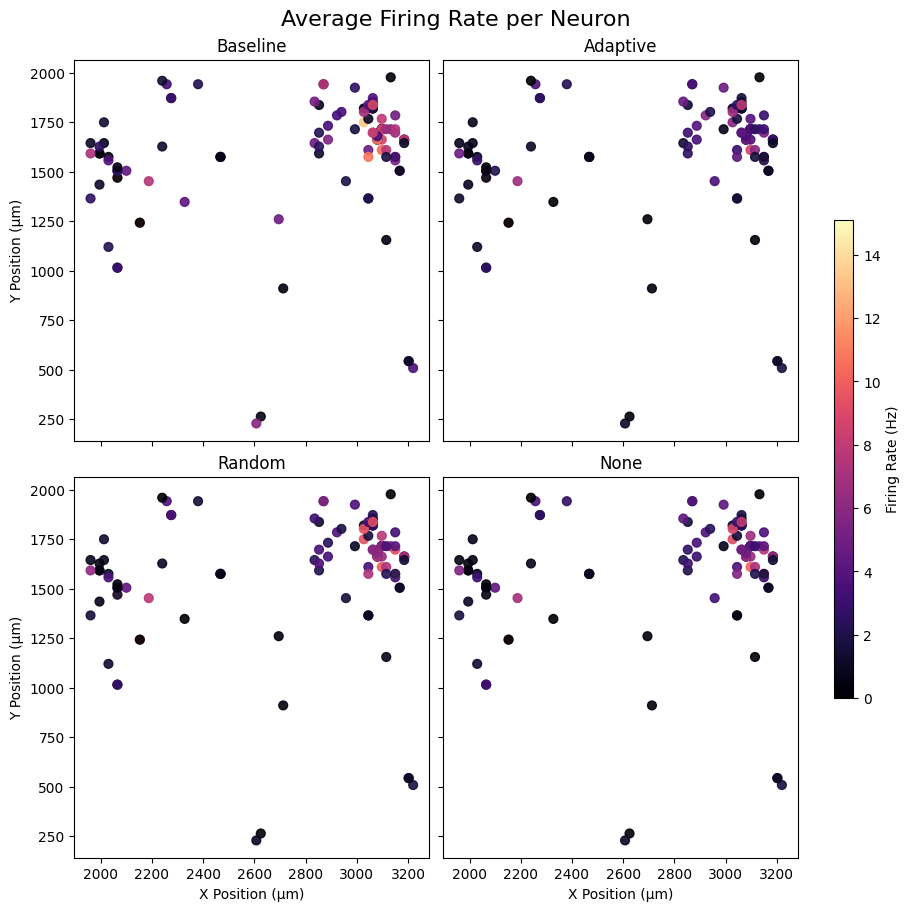

In [108]:
print("Generating Firing Rate Plot...")
# Enable constrained_layout=True
fig_fr, axs_fr = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True,
                              constrained_layout=True)
axs_fr = axs_fr.flatten()
fig_fr.suptitle('Average Firing Rate per Neuron', fontsize=16)

norm_fr = mcolors.Normalize(vmin=0, vmax=max_fr if max_fr > 0 else 1)
cmap_fr = plt.get_cmap('magma')
sm_fr = plt.cm.ScalarMappable(norm=norm_fr, cmap=cmap_fr)

plot_names = list(all_sds.keys())
plotted_something_fr = False
for i, ax in enumerate(axs_fr):
    name = plot_names[i]
    if name in infos and infos[name]['fr'].size > 0 and spike_locs.size > 0:
        current_n = infos[name]['fr'].shape[0]
        if spike_locs.shape[0] == current_n:
             sc = ax.scatter(spikes_x, spikes_y, c=infos[name]['fr'], cmap=cmap_fr, norm=norm_fr, s=40, alpha=0.9)
             plotted_something_fr = True
        elif spike_locs.shape[0] > current_n:
             print(f"Warning: Mismatch in neuron count for FR plot {name}. Plotting subset.")
             sc = ax.scatter(spikes_x[:current_n], spikes_y[:current_n], c=infos[name]['fr'], cmap=cmap_fr, norm=norm_fr, s=40, alpha=0.9)
             plotted_something_fr = True
        else:
             print(f"Error: Not enough spike locations for FR plot {name}.")
             ax.set_title(f"{name} (Plotting Error)")
             ax.axis('off')
             continue

        ax.set_title(name)
        if i >= 2: ax.set_xlabel('X Position (µm)')
        if i % 2 == 0: ax.set_ylabel('Y Position (µm)')
    else:
        ax.set_title(f"{name} (No Data)")
        ax.axis('off')

# Add a single colorbar for the figure IF something was plotted
if plotted_something_fr:
    # Constrained layout works well with ax=list
    # Adjust shrink and aspect as needed
    fig_fr.colorbar(sm_fr, ax=axs_fr.tolist(), shrink=0.6, aspect=25, label='Firing Rate (Hz)')
else:
    print("Warning: No Firing Rate data plotted, skipping colorbar.")

# No plt.tight_layout() needed when using constrained_layout=True
plt.show()

Generating STTC Plot...


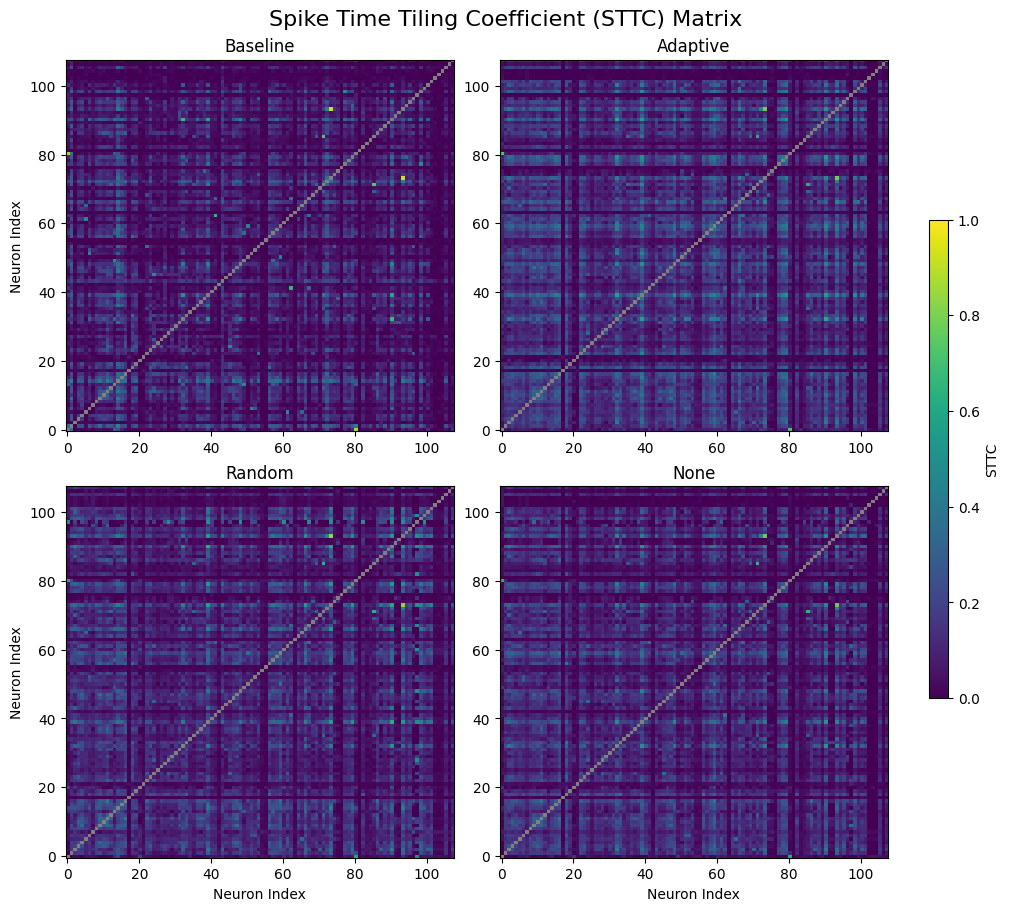

In [110]:
# ====== Plot 3: Spike Time Tiling Coefficient (STTC) ======
print("Generating STTC Plot...")
# Enable constrained_layout=True
fig_sttc, axs_sttc = plt.subplots(2, 2, figsize=(10, 9),
                                  constrained_layout=True)
axs_sttc = axs_sttc.flatten()
fig_sttc.suptitle('Spike Time Tiling Coefficient (STTC) Matrix', fontsize=16)

norm_sttc = mcolors.Normalize(vmin=0, vmax=1)
cmap_sttc = plt.get_cmap('viridis')
cmap_sttc.set_bad(color='grey')

last_im = None
for i, ax in enumerate(axs_sttc):
    name = plot_names[i]
    if name in infos and infos[name]['sttc'].size > 0:
        im = ax.imshow(infos[name]['sttc'], cmap=cmap_sttc, norm=norm_sttc, origin='lower', interpolation='nearest', aspect='auto')
        last_im = im
        ax.set_title(name)
        if i >= 2: ax.set_xlabel('Neuron Index')
        if i % 2 == 0: ax.set_ylabel('Neuron Index')
    else:
        ax.set_title(f"{name} (No STTC Data)")
        ax.axis('off')

# Add a single colorbar, referencing the last image object plotted
if last_im is not None:
    # Constrained layout works well with ax=list
    fig_sttc.colorbar(last_im, ax=axs_sttc.tolist(), shrink=0.6, aspect=25, label='STTC')
else:
    print("Warning: No STTC data plotted, skipping colorbar.")

# No plt.tight_layout() needed when using constrained_layout=True
plt.show()

Generating Raster Plot...


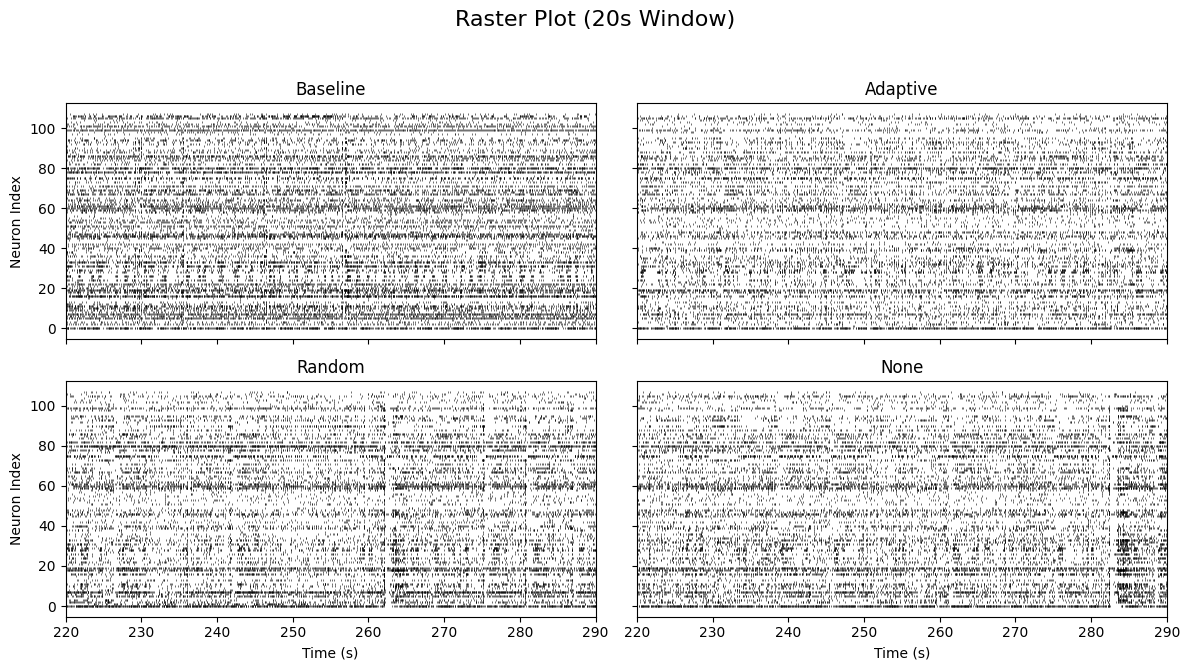

In [112]:
# ====== Plot 4: Raster Plots ======
print("Generating Raster Plot...")
# Adjusted figsize for potentially better width/height ratio
fig_raster, axs_raster = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
axs_raster = axs_raster.flatten()
fig_raster.suptitle('Raster Plot (20s Window)', fontsize=16)

# Define time window (start and end in seconds)
raster_start_s = 220
raster_end_s = 290

for i, ax in enumerate(axs_raster):
    name = plot_names[i]
    sd = all_sds[name]
    if sd.N > 0:
        idces, times = sd.idces_times()
        times_sec = times / 1000.0 # Convert ms to seconds
        mask = (times_sec >= raster_start_s) & (times_sec <= raster_end_s)
        if np.any(mask): # Check if there are any spikes in the window
             ax.scatter(times_sec[mask], idces[mask], s=1.5, c='k', marker='|', alpha=0.8, linewidths=0.5) # Slightly thicker markers
             ax.set_title(name)
             ax.set_xlim(raster_start_s, raster_end_s)
             if i >= 2: # Add x-label only to bottom row
                  ax.set_xlabel('Time (s)')
             if i % 2 == 0: # Add y-label only to left column
                  ax.set_ylabel('Neuron Index')
             ax.invert_yaxis() # Typically neuron 0 is at the top
             # Optionally set y-limits based on max neuron index if needed
             # ax.set_ylim(sd.N, -1)
        else:
             ax.set_title(f"{name} (No Spikes in Window)")
             ax.set_xlim(raster_start_s, raster_end_s)
             if i >= 2: ax.set_xlabel('Time (s)')
             if i % 2 == 0: ax.set_ylabel('Neuron Index')
             # ax.set_yticks([]) # Remove y-ticks if no spikes
    else:
        ax.set_title(f"{name} (No Spikes)")
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# <font color="blue">Stim Pulses

## <font color="red">Legacy

Prebuilt function used to plot the square wave stimulation example shown in the notebook :

In [ ]:
def plotPulse():
    t,signal =  getTimeSignal(60)
    signal = squareWave( signal, time_s=1, phase_us=200, amp_mV=150 )

    plt.plot(t,signal)
    plt.xlim([.998,1.002])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.show()

## <font color="blue"> General Stim Functions

In [ ]:
def plotStimPattern(signal,t):
    plt.plot(t,signal.T)
    plt.legend(['n0','n1','n2'])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.title("Stim Pattern over 1 Second")
    plt.show()

In [ ]:
def plotIndividualPatterns(signal,t):
    names=["n0","n1","n2"]
    color=["b","#F97306","g"]
    plt.figure(figsize=(16,4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.plot(t,signal[i], color=color[i])
        plt.legend([f"n{i}"])
        plt.ylabel('Voltage (mv)')
        plt.xlabel('seconds')
        plt.show

A helper function used in `create_stim_pulse_sequence`

In [ ]:
def insert_square_wave_advanced(sig,time,phase_length=20, amplitude=1):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+phase_length] = amplitude
    sig[time+phase_length:time+phase_length*2] = -amplitude
    return sig

Main function used to create stim pulse sequences :

In [ ]:
def create_stim_pulse_sequence(stim_list, freq_Hz=None, time_arr = None,max_time_s = 1):
    """
    Creates a stim pulse sequence, parallels the real code that will run on the Maxwell
    
    Params:
    stim_list - list of tuples indicating the commands to run
            ------------------------------------------------
            For 'stim' command:
            ('stim', [neuron inds], mv, us per phase)

            For 'delay'
            ('delay', frames_delay)
            
            For 'next'
            ('next', None)
            This command acts as a placeholder to move to the next timepoint in the time_arr or the next
            period triggered by the freq_Hz
            -------------------------------------------------
    freq_Hz - frequency to call the top stim_list in
            *Note* this takes priority over time_arr
    time_arr - array of time values that will be when the stimulations occur in order
    
    max_time_s - time in seconds to stimulate
    
    
    Returns:
    sig - np.array -- shape=(n_neurons, timesteps) of what the signal will look like
    t - np.array   -- shape=(timesteps) of time in seconds
    """
    
    # Since this is fake, only parallels the code on the device,
    # We have to make our own time
    # And simulate what the stimulation will look like
    
    # Conversion paramerters
    fs_ms = 20 # Good for converting frames to ms
    fs_us = .2
    
    # stim list
    seq = ('next',None)
    stim_list.append(seq)
    stim_list=stim_list*freq_Hz
    
    # Setup
    fs = 20000
    n_neurons = 3
    t = np.arange(0,fs*max_time_s)/fs
    sig = np.zeros(shape=(n_neurons,t.shape[0]))
    
    
    # This would be generated in *real time*
    if freq_Hz is not None:
        # Until the time is right to stimulation the sequence
        for time in t[::fs//freq_Hz]:
            time_frames = int(time*fs)
            
            
            if len(stim_list) == 0:
                return sig
            
            #Build the sequence
            command = None
            
            while (command != 'next'):
                command, *params = stim_list.pop(0) # Get first thing off list
                if command == 'stim':
                    neurons, amplitude, phase_length = params
                    phase_length = int(phase_length*fs_us)
                    
                    # Change signal for each neuron
                    for n in neurons:
                        sig[n,:] = insert_square_wave_advanced(sig[n,:],time_frames,phase_length, amplitude=amplitude)
                    time_frames += phase_length*2
                    
                if command == 'delay':
                    time_frames += fs_ms*params[0]
                    
                #double checking here
                if command == 'next':
                    break 
                    
        return sig,t

Example

In [ ]:
# stim_pattern = []
# stim_pattern.append(('stim',[0],150,200))
# stim_pattern.append(('delay',20))
# stim_pattern.append(('stim',[1],200,20))
# #stim_pattern.append(('delay',250))
# #stim_pattern.append(('stim',[0,1,2],150,20))
# signal,t = create_stim_pulse_sequence(stim_pattern, freq_Hz=1)

# <font color="red">Bookend

In [ ]:
now = datetime.now(Timezone)
printNow = now.strftime("%Y/%m/%d %H:%M:%S")

print(f"Done at: {printNow}")

Done at: 2024/06/03 16:27:28
